In [27]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from ultralytics.models.yolo.detect.train import DetectionModel
import torch
from segment_anything import SamPredictor, sam_model_registry

%reload_kedro
model_description = catalog.load("yolov8_l_description")
# trained_model = catalog.load("trained_model", version="2023-03-23T12.37.00.000Z")
# trained_model = torch.load("../checkpoints/checkpoint_40586.pt", map_location="cpu")

# Random model
encoder = YoloEncoder(model_description=model_description)
trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov8l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

# SAM model
#sam = sam_model_registry["vit_b"](checkpoint="../sam_vit_b_01ec64.pth")
#predictor = SamPredictor(sam)

# def trained_model(image):
#     predictor.set_image(image[0])
#     rep = predictor.get_image_embedding()
#     return torch.mean(rep, dim=(2, 3))

projection = trained_model.projection
trained_model = trained_model.encoder
trained_model = trained_model.eval()
projection = projection.eval()

2024-03-11 15:55:11,997 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2024-03-11 15:55:11,999 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2024-03-11 15:55:12,112 - kedro.ipython - INFO - Kedro project Self-Supervised Learning
2024-03-11 15:55:12,112 - kedro.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2024-03-11 15:55:12,117 - kedro.io.data_catalog - INFO - Loading data from 'yolov8_l_description' (YAMLDataSet)...

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]           

In [28]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "active_1" / "images"

In [29]:
# import random
# random.sample(range(160), 10)

# indices = [143, 159, 78, 12, 34, 116, 118, 0, 44, 124]

In [30]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch
from typing import Tuple, List
import numpy as np

def extract_image_reps(image_list: List[Path]) -> Tuple[List[np.array], List[np.array]]:
    image_reps = []
    image_reps_low_dim = []

    for image_path in tqdm(image_list):
        image = read_image(image_path.as_posix())
        image.requires_grad = False
        image = resize(image, (512, 512))
        image = image.to(torch.float) / 255
        image_ex = image[None, :, :, :]

        image_rep = trained_model(image_ex).detach()
        image_reps.append(image_rep[0].reshape((1, -1)).numpy())
                          
    return image_reps, image_reps_low_dim


def extract_image_reps_dir(image_dir_: Path) -> Tuple[List[np.array], List[np.array]]:
    image_list = sorted(list(image_dir_.iterdir()))
    return extract_image_reps(image_list)
                          
image_reps, image_reps_low_dim = extract_image_reps_dir(image_dir)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:24<00:00,  6.47it/s]


In [31]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "active_1" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
# labels_list = [labels_list[i] for i in indices]
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.386324,0.308469,0.030488,0.046636,p0_P1090018.txt
1,0,0.284843,0.252320,0.026132,0.038283,p0_P1090081.txt
2,0,0.448606,0.327726,0.013937,0.029002,p0_P1090300.txt
3,0,0.138937,0.221578,0.023519,0.032483,p0_P1090300.txt
4,0,0.030488,0.099768,0.024390,0.034803,p0_P1090300.txt
...,...,...,...,...,...,...
300,0,0.309612,0.294762,0.010253,0.014188,p9_P1680757.txt
301,0,0.365584,0.297645,0.009460,0.017842,p9_P1680757.txt
302,0,0.500000,0.379350,0.013937,0.016241,p9_P1680757.txt
303,0,0.908537,0.736079,0.012195,0.017401,p9_P1680757.txt


In [32]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [33]:
test_image_dir = dataset_path / "2018-08-22" / "images"

test_image_reps, test_image_reps_low_dim = extract_image_reps_dir(test_image_dir)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:24<00:00,  6.44it/s]


In [34]:
test_labels_dir = dataset_path / "2018-08-22" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.414497,0.818287,0.039062,0.046296,p0_P2530585.txt
1,0,0.245660,0.649884,0.019097,0.028935,p0_P2530668.txt
2,0,0.636719,0.209491,0.018229,0.025463,p0_P2530668.txt
3,0,0.827691,0.566551,0.019965,0.026620,p0_P2530668.txt
4,0,0.392734,0.709734,0.022448,0.033588,p0_P2530668.txt
...,...,...,...,...,...,...
382,0,0.053385,0.823495,0.021701,0.028935,p9_P2540369.txt
383,0,0.441840,0.266204,0.019097,0.025463,p9_P2540369.txt
384,0,0.533854,0.799769,0.032986,0.041667,p9_P2540420.txt
385,0,0.404948,0.767361,0.019965,0.025463,p9_P2540420.txt


In [35]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [36]:
from sklearn.model_selection import PredefinedSplit

# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = [-1] * len(image_reps)
test_indices = [0] * len(test_image_reps)
split = PredefinedSplit(train_indices + test_indices)

In [37]:
from sklearn.linear_model import RidgeCV, Ridge

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg_search = RidgeCV(alphas=alphas, cv=split).fit(all_image_reps_arr, all_flower_counts)
# RidgeCV is going to go and refit on the whole dataset once it finds the best alpha, which we don't want.
# Fit manually with the best alpha on just the training data.
reg = Ridge(reg_search.alpha_).fit(np.concatenate(image_reps, axis=0), np.array(flower_counts))

In [38]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([     1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,
            1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,
            1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,
            1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,
            1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,
            1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,
            1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062,      1.9062], dtype=float32)

In [49]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 errors = test_preds - test_flower_counts                                                     │
│   2 print(test_flower_counts)                                                                    │
│   3 np.mean(np.abs(errors))                                                                      │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: operands could not be broadcast together with shapes (20,) (160,)

In [40]:
# Calculate MAPE.
errors = np.abs(test_preds - test_flower_counts) / ((np.abs(test_preds) + np.abs(test_flower_counts)) / 2) * 100
np.mean(errors)

90.96686932366106

2024-03-11 15:56:32,564 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2024-03-11 15:56:32,565 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



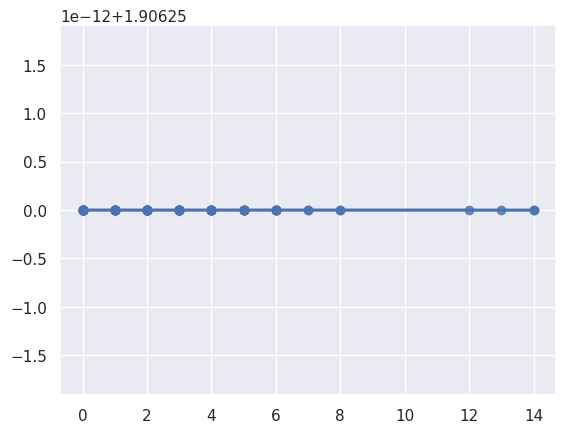

In [41]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_flower_counts, y=test_preds)
plt.show()

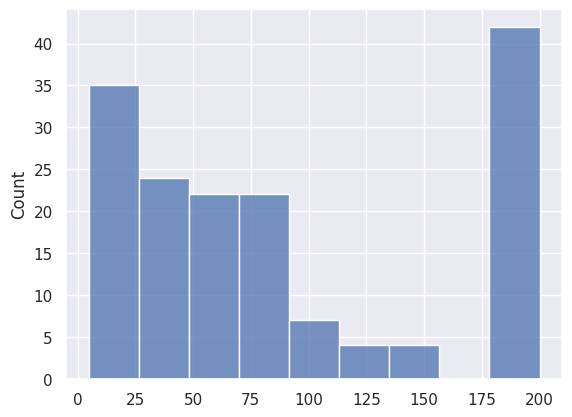

In [42]:
sns.histplot(x=errors)

In [43]:
# Load the plot status data.
PLOT_STATUS_DATA_PATH = Path("/home/daniel/lab_share/projects/SSL/plot_status_dataset")
train_dir = PLOT_STATUS_DATA_PATH / "train"
test_dir = PLOT_STATUS_DATA_PATH / "test"

LABEL_MAP = {"in_plot": 0, "between_plots": 1, "headland": 2}

def collect_images_and_labels(data_dir: Path) -> Tuple[List[Path], np.array]:
    image_paths = []
    labels = []
    
    for category_dir in data_dir.iterdir():
        for image_path in category_dir.iterdir():
            image_paths.append(image_path)
            labels.append(LABEL_MAP[category_dir.name])
            
    return image_paths, np.array(labels)

train_images, train_labels = collect_images_and_labels(train_dir)
test_images, test_labels = collect_images_and_labels(test_dir)

In [44]:
# Compute image representations.
train_image_reps, _ = extract_image_reps(train_images)
test_image_reps, _ = extract_image_reps(test_images)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.56it/s]


In [45]:
# Create combined dataset.
all_image_reps = np.concatenate(train_image_reps + test_image_reps, axis=0)
all_plot_status = np.concatenate([train_labels, test_labels], axis=0)
train_indices = [-1] * len(train_image_reps)
test_indices = [0] * len(test_image_reps)
split = PredefinedSplit(train_indices + test_indices)

In [46]:
# Fit the model.
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

alphas = [1e-4, 0.01, 0.1, 1.0, 2.0, 8.0, 32.0, 64.0, 128.0]
reg_search = LogisticRegressionCV(Cs=alphas, cv=split).fit(all_image_reps, all_plot_status)
# LogisticRegressionCV is going to go and refit on the whole dataset once it finds the best alpha, which we don't want.
# Fit manually with the best alpha on just the training data.
reg = LogisticRegression(C=np.mean(reg_search.C_)).fit(np.concatenate(train_image_reps, axis=0), train_labels)

In [47]:
# Compute predictions on test set.
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
# Calculate accuracy.
test_accuracy = np.sum(test_preds == test_labels) / len(test_labels)
test_accuracy

0.45